In [ ]:
!pip install transformers
!pip install torch
!pip install newspaper3k
!pip install bs4
!pip install joblib
!pip install nltk


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Epoch 1/5
22/22 [==============================] - 9s 337ms/step - loss: 0.6345 - accuracy: 0.6889 - val_loss: 0.5235 - val_accuracy: 0.7633
Epoch 2/5
22/22 [==============================] - 9s 388ms/step - loss: 0.3480 - accuracy: 0.8919 - val_loss: 0.3596 - val_accuracy: 0.8728
Epoch 3/5
22/22 [==============================] - 8s 354ms/step - loss: 0.1710 - accuracy: 0.9815 - val_loss: 0.2791 - val_accuracy: 0.9053
Epoch 4/5
22/22 [==============================] - 9s 408ms/step - loss: 0.0541 - accuracy: 0.9985 - val_loss: 0.2230 - val_accuracy: 0.8994
Epoch 5/5
11/11 [==============================] - 0s 20ms/step
SVM Model Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       623
           1       1.00      1.00      1.00       727

    accuracy                           1.00      1350
   macro avg       1.00      1.00      1.00      1350
weighted avg       1.00      1.00      1.00      1350

Nai

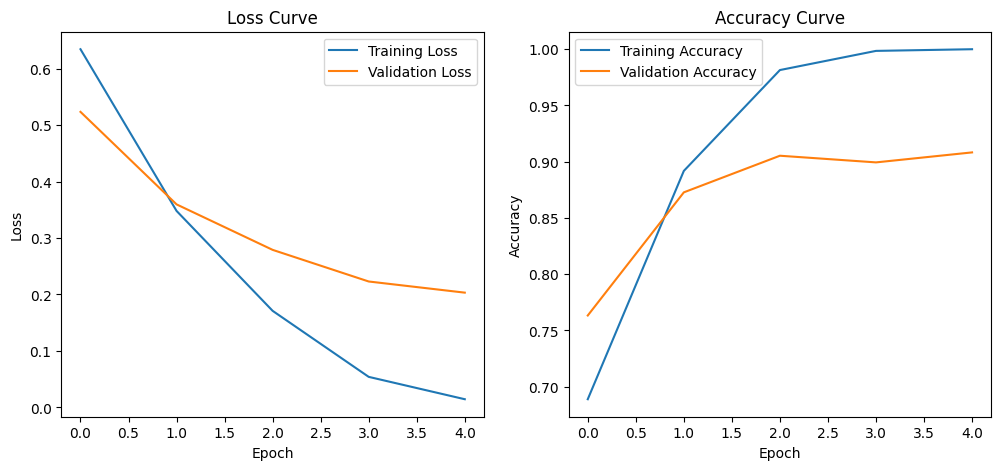

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
import string
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.utils import to_categorical
import pickle
from joblib import dump
import matplotlib.pyplot as plt

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv('updated_big_train.csv')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply preprocessing
data['lemmatized'] = data['lemmatized'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['lemmatized'], data['label'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train an SVM model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

# Train a Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# CNN Parameters
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# Tokenize the text data for CNN
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['lemmatized'].values)
X = tokenizer.texts_to_sequences(data['lemmatized'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = to_categorical(data['label'])

# Split the data for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=64, validation_data=(X_test_cnn, y_test_cnn))

# Evaluate the models
y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_nb = nb_model.predict(X_test_tfidf)
y_pred_cnn = cnn_model.predict(X_test_cnn).argmax(axis=1)

# Print classification reports
print("SVM Model Training Classification Report:")
y_train_pred_svm = svm_model.predict(X_train_tfidf)
print(classification_report(y_train, y_train_pred_svm))

print("Naive Bayes Model Training Classification Report:")
y_train_pred_nb = nb_model.predict(X_train_tfidf)
print(classification_report(y_train, y_train_pred_nb))

print("SVM Model Test Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Naive Bayes Model Test Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("CNN Model Test Classification Report:")
print(classification_report(y_test_cnn.argmax(axis=1), y_pred_cnn))

# Plot loss and accuracy curves for CNN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

# Save the models and tokenizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

dump(tokenizer, 'tokenizer.pkl')

cnn_model.save('cnn_model.keras')


In [ ]:
!pip install newspaper3k
import requests
from bs4 import BeautifulSoup
from newspaper import Article
import joblib
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import string
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Load models and vectorizer
svm_model = joblib.load('svm_model.pkl')
nb_model = joblib.load('nb_model.pkl')
cnn_model = load_model('cnn_model.keras', compile=False)
tokenizer = joblib.load('tokenizer.pkl')
vectorizer = joblib.load('vectorizer.pkl')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
distilbert_model.eval()

def classify_article_distilbert(text):
    inputs = distilbert_tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).numpy()[0]
    label = np.argmax(probabilities)
    return ('Adverse Media' if label == 1 else 'Non-Adverse Media', max(probabilities))

def classify_article_svm(text):
    text_tfidf = vectorizer.transform([text])
    label = svm_model.predict(text_tfidf)[0]
    score = svm_model.decision_function(text_tfidf)[0]
    return ('Adverse Media' if label == 1 else 'Non-Adverse Media', score)

def classify_article_nb(text):
    text_tfidf = vectorizer.transform([text])
    label = nb_model.predict(text_tfidf)[0]
    score = max(nb_model.predict_proba(text_tfidf)[0])
    return ('Adverse Media' if label == 1 else 'Non-Adverse Media', score)

def classify_article_cnn(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=250)
    label = cnn_model.predict(text_pad)[0]
    return ('Adverse Media' if np.argmax(label) == 1 else 'Non-Adverse Media', max(label))

def fetch_articles(query, num_articles=20):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    search_url = f"https://www.google.com/search?q={query}&tbm=nws&num={num_articles}"
    response = requests.get(search_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    links = []
    for link in soup.find_all('a'):
        url = link.get('href')
        if url and 'http' in url and 'google.com' not in url:
            if url.startswith('/url?q='):
                url = url.split('&')[0].replace('/url?q=', '')
            links.append(url)

    return links[:num_articles]

def process_article(url, query):
    try:
        article = Article(url)
        article.download()
        article.parse()
        title = article.title
        text = article.text

        if query.lower() not in text.lower():
            return None

        svm_class, svm_score = classify_article_svm(text)
        nb_class, nb_score = classify_article_nb(text)
        cnn_class, cnn_score = classify_article_cnn(text)
        distilbert_class, distilbert_score = classify_article_distilbert(text)

        if svm_class == 'Adverse Media' and svm_score >= 0.575:
            return title, url, svm_class, svm_score, 'SVM'
        if nb_class == 'Adverse Media' and nb_score >= 0.575:
            return title, url, nb_class, nb_score, 'Naive Bayes'
        if cnn_class == 'Adverse Media' and cnn_score >= 0.575:
            return title, url, cnn_class, cnn_score, 'CNN'
        if distilbert_class == 'Adverse Media' and distilbert_score >= 0.575:
            return title, url, distilbert_class, distilbert_score, 'DistilBERT'

    except Exception as e:
        print(f"Error processing article {url}: {e}")
        return None

name = input("Enter the name of the person or company: ")
fuzzy = input("Press 1 to enable fuzzy match, 0 to disable fuzzy match: ")

while fuzzy not in ['0', '1']:
    fuzzy = input("Invalid input. Please choose a valid option: 1 or 0: ")

if fuzzy == '1':
    dob = input("Enter the date of birth (format: YYYY-MM-DD): ")
    dob_formatted = dob.replace('/', '-')
    query = f"{name} {dob_formatted}"
else:
    query = name

print(f"Query: {query}")
links = fetch_articles(query, num_articles=20)

with ThreadPoolExecutor(max_workers=50) as executor:
    future_to_url = {executor.submit(process_article, url, query): url for url in links}
    results = []
    for future in as_completed(future_to_url):
        result = future.result()
        if result is not None:
            results.append(result)

adverse_articles = [result for result in results if result is not None]

if adverse_articles:
    for i, (title, url, classification, score, model) in enumerate(adverse_articles):
        print(f"Article {i+1}:")
        print(f"Title: {title}")
        print(f"URL: {url}")
        print(f"Classification: {classification}, Score: {score}")
        print(f"Model: {model}")
        print("\n" + "="*80 + "\n")
else:
    print("No adverse media articles found.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter the name of the person or company: Woolworths Group
Press 1 to enable fuzzy match, 0 to disable fuzzy match: 0
Query: Woolworths Group
Error processing article https://www.reuters.com/business/retail-consumer/australian-retailer-woolworths-sell-303-mln-stake-endeavour-group-2024-04-30/: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/business/retail-consumer/australian-retailer-woolworths-sell-303-mln-stake-endeavour-group-2024-04-30/ on URL https://www.reuters.com/business/retail-consumer/australian-retailer-woolworths-sell-303-mln-stake-endeavour-group-2024-04-30/
1/1 [==============================] - 0s 310ms/step
Article 1:
Title: Australian Paralympian Col Pearse stars in Woolworths' "Fresh Fuels the Best in All of Us" Campaign
URL: https://woolworthsgroup.com.au/au/en/media/latest-news/2024/australian-paralympian-col-pearse-stars-in-woolworths---fresh-fu.html
Classification: Adverse Media, Score: 0.5882713544683903
Model: 